# S1 Coursework

Yuanzhen Zhao (yz929)

In [3]:
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad, dblquad
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from dists import *
import timeit

In [4]:
# Parameters
mu, sigma, beta, m, f, lmda, mu_b, sigma_b = 3, 0.3, 1, 1.4, 0.6, 0.3, 0, 2.5

## Question b

In [ ]:
# Check if normalisation is satisfied
print("CDF of g_s in range x=[0,5] is", quad(g_s, 0, 5, args=(beta, m, mu, sigma))[0])
print("CDF of h_s in range y=[0,10] is", quad(h_s, 0, 10, args=lmda)[0])
print("CDF of g_b in range x=[0,5] is", quad(g_b, 0, 5)[0])
print("CDF of h_b in range y=[0,10] is", quad(h_b, 0, 10, args=(mu_b, sigma_b))[0])
print("CDF of s_xy in range x=[0,5], y=[0,10] is", dblquad(s_xy, 0, 5, 0, 10, args=(beta, m, mu, sigma, lmda))[0])
print("CDF of b_xy in range x=[0,5], y=[0,10] is", dblquad(b_xy, 0, 5, 0, 10, args=(mu_b, sigma_b))[0])
print("CDF of f_xy in range x=[0,5], y=[0,10] is", dblquad(f_xy, 0, 5, 0, 10, args=(mu, sigma, beta, m, f, lmda, mu_b, sigma_b))[0])

CDF of g_s in range x=[0,5] is 1.0000000376260723
CDF of h_s in range y=[0,10] is 1.0
CDF of g_b in range x=[0,5] is 1.0000000000000002
CDF of h_b in range y=[0,10] is 1.0
CDF of s_xy in range x=[0,5], y=[0,10] is 1.0000000376260723
CDF of b_xy in range x=[0,5], y=[0,10] is 1.0000000000000002
CDF of f_xy in range x=[0,5], y=[0,10] is 1.0000000225756434


## Question c

In [39]:
x = np.linspace(0, 5, 200)
y = np.linspace(0, 10, 200)

P_x = f * g_s(x, beta, m, mu, sigma) + (1-f) * g_b(x)
P_y = f * h_s(y, lmda) + (1-f) * h_b(y, mu_b, sigma_b)

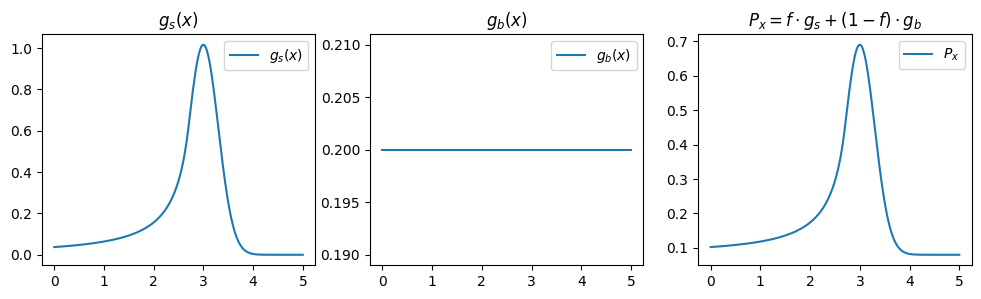

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(x, g_s(x, beta, m, mu, sigma), label='$g_s(x)$')
ax[0].set_title('$g_s(x)$')
ax[0].legend()

ax[1].plot(x, g_b(x), label='$g_b(x)$')
ax[1].set_title('$g_b(x)$')
ax[1].legend()

ax[2].plot(x, P_x, label='$P_x$')
ax[2].set_title('$P_x = f \\cdot g_s + (1-f) \\cdot g_b$')
ax[2].legend()

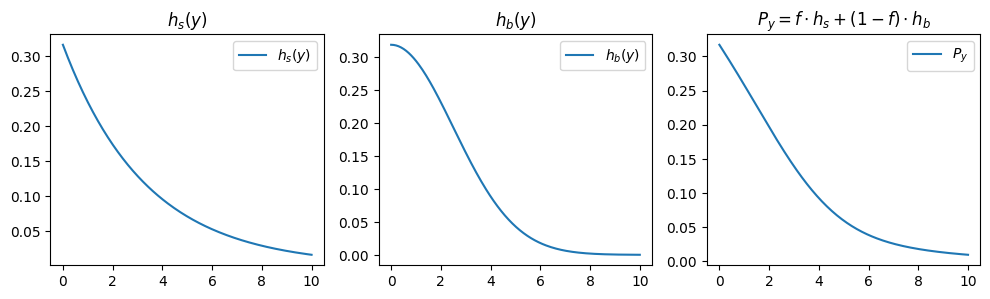

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].plot(y, h_s(y, lmda), label='$h_s(y)$')
ax[0].set_title('$h_s(y)$')
ax[0].legend()


ax[1].plot(y, h_b(y, mu_b, sigma_b), label='$h_b(y)$')
ax[1].set_title('$h_b(y)$')
ax[1].legend()

ax[2].plot(y, P_y, label='$P_y$')
ax[2].set_title('$P_y = f \\cdot h_s + (1-f) \\cdot h_b$')
ax[2].legend()

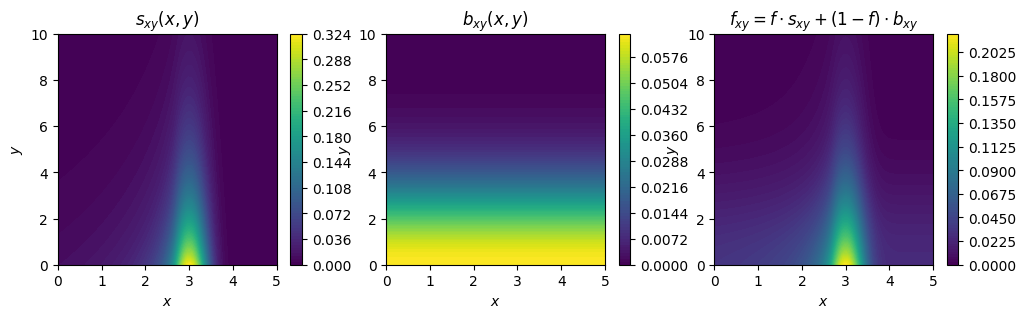

In [48]:
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

sxy = ax[0].contourf(X, Y, s_xy(Y, X, beta, m, mu, sigma, lmda), levels=100)
ax[0].set_title('$s_{xy}(x,y)$')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
fig.colorbar(sxy, ax=ax[0])

bxy = ax[1].contourf(X, Y, b_xy(Y, X, mu_b, sigma_b), levels=100)
ax[1].set_title('$b_{xy}(x,y)$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
fig.colorbar(bxy, ax=ax[1])

fxy = ax[2].contourf(X, Y, f_xy(Y, X, mu, sigma, beta, m, f, lmda, mu_b, sigma_b), levels=100)
ax[2].set_title('$f_{xy} = f \\cdot s_{xy} + (1-f) \\cdot b_{xy}$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
fig.colorbar(fxy, ax=ax[2])

plt.show()


## Question d

从联合分布中生成一个高统计量样本，共包含 100,000 个事件，然后执行扩展最大似然拟合以估计九个参数（注意，由于拟合是扩展的，所以多了一个自由参数）。您还应确定这些估计值的不确定性估计值。请使用 timeit 库评估下列进程 100 次调用的平均执行时间：

In [6]:
%timeit  np.random.normal(size=100000)

1.29 ms ± 17.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def generate_sample(num_events=100000):
    np.random.seed(50)
    N = np.random.poisson(num_events)

    x_values = np.random.uniform(0, 5, N)
    y_values = np.random.uniform(0, 10, N)
    
    return np.column_stack((x_values, y_values))

dataset = generate_sample(100000)

In [17]:
def log_pdf(xy, mu, sigma, beta, m, f, lmda, mu_b, sigma_b, N):
    x, y = xy
    total_likelihood = f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)
    log_likelihood = np.log(total_likelihood + 1e-10)
    lnL = log_likelihood.sum() + N*np.log(num_events+1e-10) - num_events
    
    return -lnL, -log_likelihood

In [19]:
def log_pdf(xy, mu, sigma, beta, m, f, lmda, mu_b, sigma_b, N):
    x, y = xy
    return N, N * f_xy(y, x, mu, sigma, beta, m, f, lmda, mu_b, sigma_b)

In [20]:
nll = ExtendedUnbinnedNLL((dataset[:,0], dataset[:,1]), log_pdf, log=False)

mi = Minuit(nll, mu=3, sigma=0.3, beta=1, m=1.4, f=0.6, lmda=0.3, mu_b=0, sigma_b=2.5, N=100000)

mi.limits["mu"]=(0, 5)
mi.limits["sigma"]=(0, 3)
mi.limits["beta"]=(0, 3)
mi.limits["m"]=(1, 2)
mi.limits["f"]=(0, 1)
mi.limits["lmda"]=(0, 1)
mi.limits["mu_b"]=(-5,5)
mi.limits["sigma_b"]=(0,5)
mi.limits["N"]=(0, None)

mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.32e+06                  │             Nfcn = 2637              │
│ EDM = 0.00986 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu      │   4.20    │   0.27    │            │            │    0    │    5    │       │
│ 1 │ sigma   │    2.5    │    0.9    │            │            │    0    │    3    │       │
│ 2 │ beta    │   0.001   │   0.015   │            │            │    0    │    3    │       │
│ 3 │ m       │    1.4    │    0.7    │            │            │    1    │    2    │       │
│ 4 │ f       │   0.993   │   0.004   │            │            │    0    │    1    │       │
│ 5 │ lmda    │  0.0000   │  0.0021   │            │            │    0    │    1    │       │
│ 6 │ mu_b    │    -5     │     8     │            │            │   -5    │    5    │       │
│ 7 │ sigma_b │    3.9    │    1.4    │            │            │    0    │    5    │       │
│ 8 │ N       │ 99.9963e3 │ 0.0020e3  │            │            │    0    │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│         │        mu     sigma      beta         m         f      lmda      mu_b   sigma_b         N │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│      mu │    0.0743     -0.25  -0.73e-3      0.00 -0.002e-3    1.6e-9     -0.00      0.00     -0.00 │
│   sigma │     -0.25      1.14   1.03e-3      -0.0  0.018e-3   -9.0e-9       0.0      -0.0       0.0 │
│    beta │  -0.73e-3   1.03e-3  5.38e-05        -0         0   -0.1e-9  -0.02e-3  -0.02e-3         0 │
│       m │      0.00      -0.0        -0     0.984        -0         0       0.0       0.0         0 │
│       f │ -0.002e-3  0.018e-3         0        -0  1.44e-05   -3.7e-9 -1.721e-3 -2.805e-3        -0 │
│    lmda │    1.6e-9   -9.0e-9   -0.1e-9         0   -3.7e-9  9.37e-10  428.9e-9  281.3e-9         0 │
│    mu_b │     -0.00       0.0  -0.02e-3       0.0 -1.721e-3  428.9e-9      15.4      -3.8         0 │
│ sigma_b │      0.00      -0.0  -0.02e-3       0.0 -2.805e-3  281.3e-9      -3.8      2.35       0.0 │
│       N │     -0.00       0.0         0         0        -0         0         0       0.0         4 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

## Question e

Now run a simulation study using parametric bootstrapping (with an ensemble
of at least 250 samples) from the true probability distribution. You should trial
sample sizes of 500, 1000, 2500, 5000 and 10000, including a Poisson variation on
the sample size. Determine whether you see any bias on the 𝜆 parameter,
describing the decay constant of the signal in 𝑌, as a function of the sample size.
Also determine the expected uncertainty on 𝜆 as a function of the sample size.

现在进行一个模拟研究，使用参数自助法（从真实概率分布中生成至少250个样本的集合）。您应该尝试以下样本量：500、1000、2500、5000和10000，并包括样本量上的泊松变化。确定是否可以观察到𝜆参数（描述信号在𝑌中的衰减常数）的偏差随样本量的变化情况。同时，确定𝜆的预期不确定性如何随样本量的变化而变化